<a href="https://colab.research.google.com/github/PN-pitchayut/PN-pitchayut/blob/main/Test_Brain_Tumor_Classification_Trad_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization

In [ ]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI Brain Tumors/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI Brain Tumors/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 74/74 [00:12<00:00,  5.92it/s]


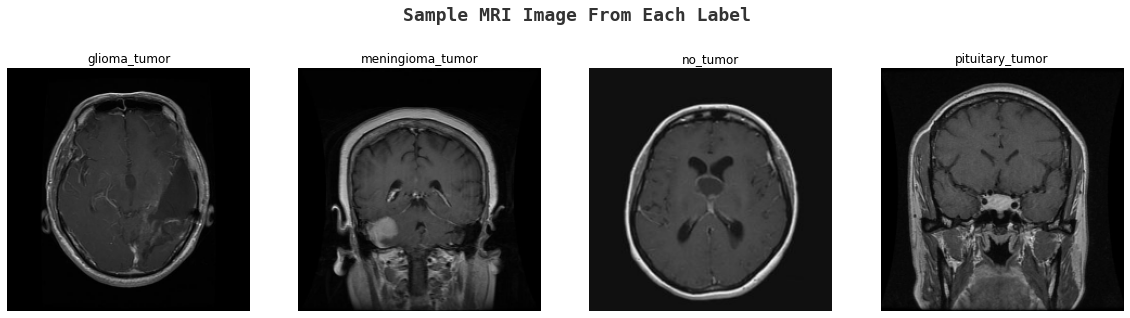

In [ ]:
#Preview the images in each class

k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample MRI Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
#shuffle the training set

X_train, y_train = shuffle(X_train,y_train, random_state=14)

In [ ]:
#Printing out the training set shape

X_train.shape

(2870, 224, 224, 3)

In [ ]:
#Printing out the test set shape

X_test.shape

(394, 224, 224, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


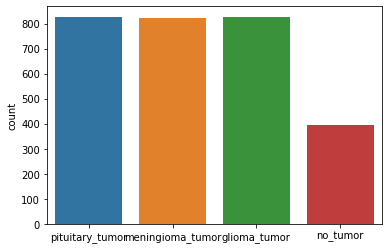

In [ ]:
#Show the count of traiing data set

sns.countplot(y_train)

In [ ]:
#Performing One Hot Encoding on the labels after converting it into numerical values

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

Data Preparation: Divided the data into training and testing sets

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=14)

In [ ]:
#Normalize the data

X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.
X_test = np.array(X_test) / 255.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.2,  # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [ ]:
#callbacks.
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

3.1 CNNs

In [ ]:
#CNN Approach

model_cnn = Sequential()

model_cnn.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization()) 
model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35)) 

model_cnn.add(Conv2D(64, (3, 3), padding='same')) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Flatten()) 
model_cnn.add(Dropout(0.5)) 
model_cnn.add(Dense(512)) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dense(4)) 
model_cnn.add(Activation('softmax'))

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                      

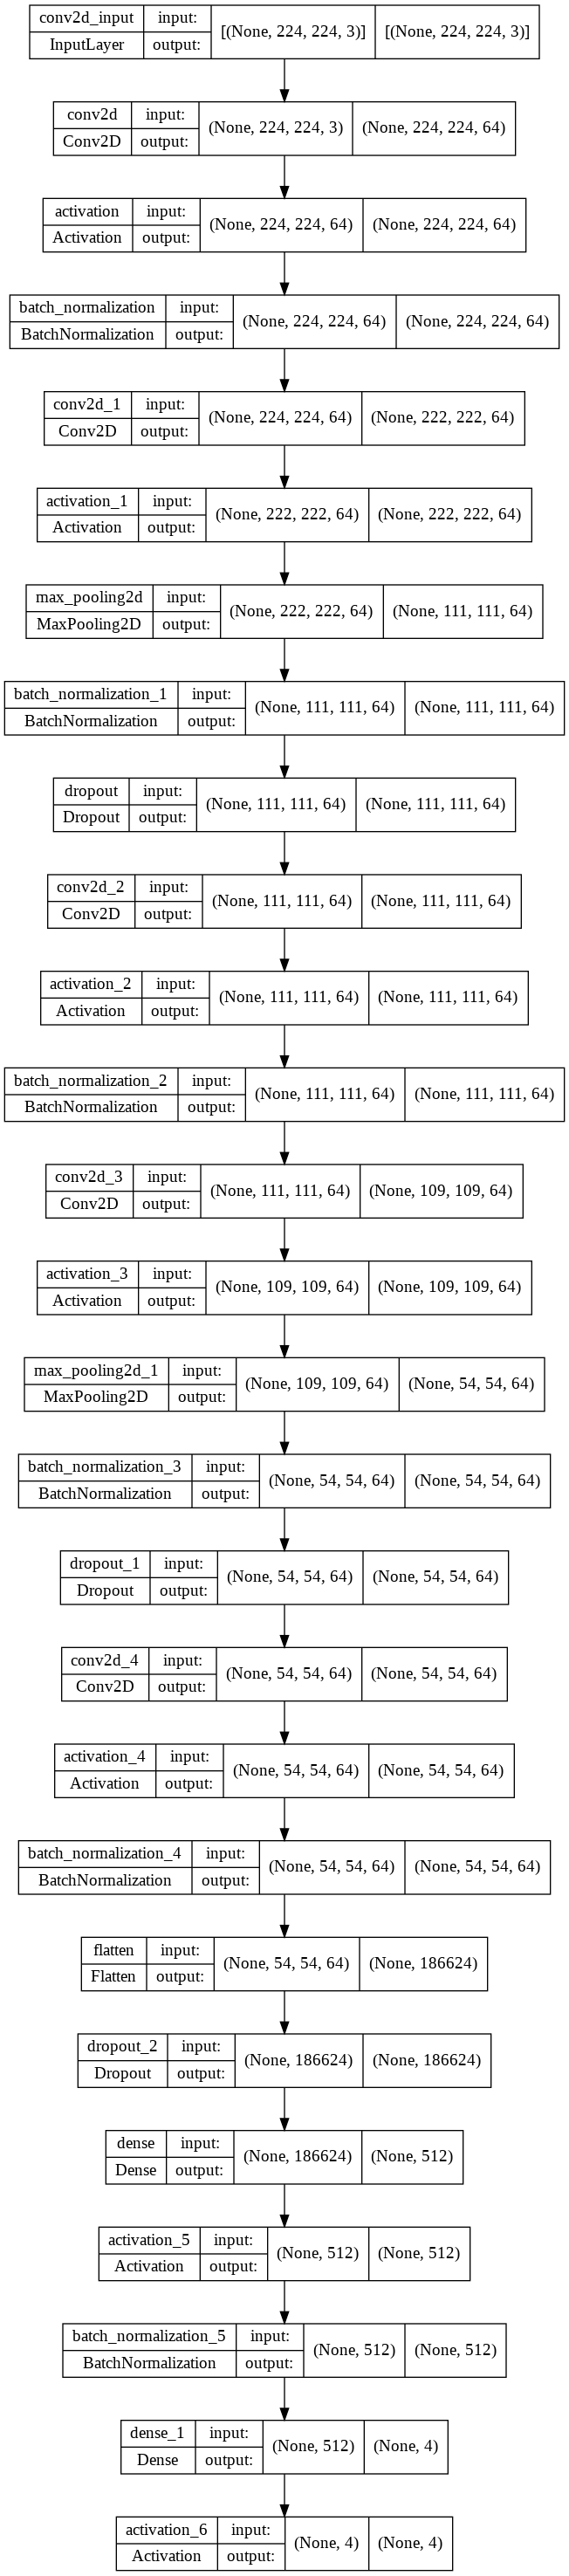

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_cnn.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

3.3 Training the model

In [ ]:
history = model_cnn.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 12, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
73/73 [==============================] - ETA: 0s - loss: 1.0934 - accuracy: 0.6837 
Epoch 1: val_accuracy improved from -inf to 0.33205, saving model to effnet.h5
73/73 [==============================] - 1285s 18s/step - loss: 1.0934 - accuracy: 0.6837 - val_loss: 7.6987 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 2/12
73/73 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.8343 
Epoch 2: val_accuracy improved from 0.33205 to 0.38610, saving model to effnet.h5
73/73 [==============================] - 1289s 18s/step - loss: 0.4387 - accuracy: 0.8343 - val_loss: 2.2091 - val_accuracy: 0.3861 - lr: 0.0010
Epoch 3/12
73/73 [==============================] - ETA: 0s - loss: 0.3170 - accuracy: 0.8851 
Epoch 3: val_accuracy improved from 0.38610 to 0.44015, saving model to effnet.h5
73/73 [==============================] - 1286s 18s/step - loss: 0.3170 - accuracy: 0.8851 - val_loss: 7.3605 - val_accuracy: 0.4402 - lr: 0.0010
Epoch 4/12
73/73 [===================

2.3 Training, loss vs epoch.

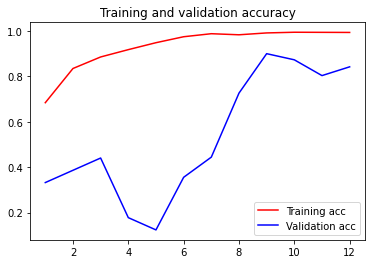

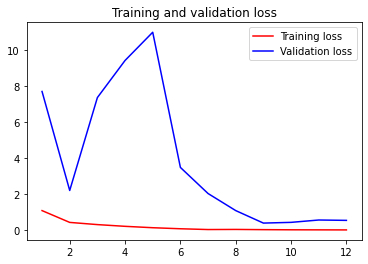

In [ ]:
model_cnn.save('cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

3.4 Model Performance

In [ ]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 72.08%


3.5 Evaluation Metrics

In [ ]:
model_cnn.evaluate(X_train, y_train)

81/81 [==============================] - 329s 4s/step - loss: 0.1436 - accuracy: 0.9578


[0.1435796320438385, 0.9578009843826294]

In [ ]:
#in this, 0=glioma, 1=meningioma, 2=no tumor and 3=pituitary tumor


print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.76      0.16      0.26       100
           1       0.76      0.87      0.81       115
           2       0.66      0.94      0.78       105
           3       0.74      0.93      0.83        74

    accuracy                           0.72       394
   macro avg       0.73      0.73      0.67       394
weighted avg       0.73      0.72      0.67       394



3.6 Confusion Matrix

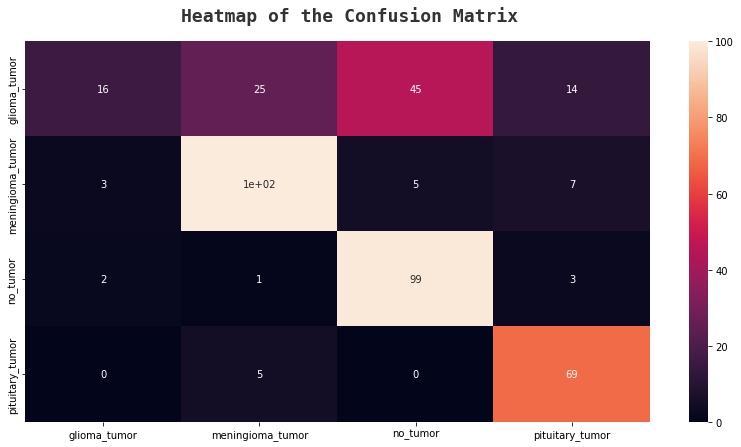

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()